# This notebook contains the following analysis/derivations:
    1. Choosing MW-like galaxies form SPARC dataset
    2. VDF of MWlike galaxies at r = 8 kpc

All the data obtained from this notebook are saved in '../Output/MWlike_dict.pkl'

# 1. Choosing MW-like galaxies from SPARC dataset 
## (already fitted with NFW profile in previous works)

## Selection criteria 
    1. M200 and Md,star of gal, within error, should be within the fiducial MW range.
    2. Rotation curve should match to each other based on the below mentioned criteria*.
    3. Morphology should be same. ( Need bulge, stellar disc scale length requirement, C200 criteria is relaxed, Rd,bul should be less than 2kpc, Rdgas should be extended and leaves a relatively large scale, ignored the 'hole' )

## *Rotation curve criteria
    Angular velocity $\omega = V(r)/r$ of the RC should match that of the MW's (compiled from PB's and Elier's works). The matching criteria is set as $\sqrt{\chi^2/d.o.f} < 60$, where \chi^2 is eq() in the paper and the degrees of freedom (d.o.f) is the total number of data points falling in the radial range 2-30 kpc (D) - 1. 

## Errors considered for mass model parameter
    - For DM halo parameters $\Delta M200, \Delta C200$ are obtained from MCMC chains.
    - The baryonic mass model parameters are assumed to have a +- 10 percent error.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json,os,sys
import pickle

In [86]:
# Importing mass model data of SPARC RCs already fitted (with NFW DM density profile) in previous works.
sparcd = json.load(open('../Accessory/sparc_dict.json','r'))
prior = 'lcdm_reg'
# Importing MW dict
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))

In [89]:
# To check if there is any overlap between the estimated (1sigma) range and the fiducial range.

RC = MW_dict['RC']
mw_r, mw_v, mw_ve = RC[:,0], RC[:,1], RC[:,2]
mw_w = mw_v/mw_r
mw_we = mw_w*(mw_ve/mw_v)

overlap = lambda a, e_a, a_min, a_max: (np.around(a - e_a,1) <= a_max) and (np.around(a + e_a,1) >= a_min)

def RC_criteria(r, vc, ve, r_min = 3.0, r_max = 30.0):
    """
    This is to check if the RC of the gal is a match to MW's. 
    Note that sparc_dict.json and MW RC data are assumed to be
    loaded and are defined as sparcd and mwd.
    -----------
    gal: (string) name of the galaxy
    """
    vc_fn = sp.interpolate.interp1d(r,vc,
                                    kind = 'cubic',
                                    bounds_error = False,
                                    fill_value = 'extrapolate')
    ve_fn = sp.interpolate.interp1d(r,ve,
                                    kind = 'cubic',
                                    bounds_error = False,
                                    fill_value = 'extrapolate')
    chisq, cnt = 0, 0
    for i in range(len(mw_r)):
        r = mw_r[i]
        if (r < r_min) or (r > r_max):
            continue
        chisq += (mw_w[i] - vc_fn(r)/r)**2/(mw_we[i]**2 + (ve_fn(r)/r)**2)
        cnt += 1
    return chisq/float(cnt - 1)

def morph_criteria(gal):
    gdict = sparcd[prior][gal]
    gald = gdict['cusp_fit']
    bulge = gdict['bulge']
    if not bulge:
        return False

    mdbul_min, mdbul_max = MW_dict['fiducial_range']['mdbul']
    mdbul_mean = 0.5*(mdbul_min + mdbul_max)
    mdbul_widt = 0.5*(mdbul_max - mdbul_min)
    mdbul_fid = [mdbul_mean - 2.2*mdbul_widt, 
                 mdbul_mean + 2.2*mdbul_widt] # it is 2.2 only
                # for UGC05253, for all other MW-like galaxies,
                # using 2 is sufficient.
    mdbul = 10**(gald['lmbul'][0]-9)
    emdbul = 0.1*mdbul
    if not overlap(mdbul, emdbul, *mdbul_fid):
        return False

    if not (gald['rdbul'][0] - gald['rdbul'][1] < 2.0):
        return False

    mdgas_min, mdgas_max = MW_dict['fiducial_range']['mdgas']
    mdgas_mean = 0.5*(mdgas_min + mdgas_max)
    mdgas_widt = 0.5*(mdgas_max - mdgas_min)
    mdgas_fid = [mdgas_mean - mdgas_widt, 
                 mdgas_mean + mdgas_widt]
    mdgas = 10**(gald['lmgas'][0]-9)
    emdgas = 0.1*mdgas
    if not overlap(mdgas, emdgas, *mdgas_fid):
        return False

    rdgas_min, rdgas_max = MW_dict['fiducial_range']['rdgas']
    rdgas_mean = 0.5*(rdgas_min + rdgas_max)
    rdgas_widt = 0.5*(rdgas_max - rdgas_min)
    rdgas_fid = [rdgas_mean - 2*rdgas_widt,
                 rdgas_mean + 2*rdgas_widt]
    rdgas = gald['rdgas'][0]
    erdgas = 0.1*rdgas
    if not overlap(rdgas, erdgas, *rdgas_fid):
        return False
    else:
        return True

In [90]:
# Selection of MW-like galaxies using criteria 1, 2 and 3
selection = {f'criteria-{i}':[] for i in range(1,4)}
selection['criteria-12'] = []
selection['criteria-123'] = []

for gal in sparcd[prior].keys():
    gdict = sparcd[prior][gal]
    gald = gdict['cusp_fit']
    
    m200, em200 = np.array(gald['m200'])*1e-12
    mdstar = 10**(gald['lmdisk'][0]-9)
    emdstar = 0.1*mdstar
    m200_fid = MW_dict['fiducial_range']['m200']
    mdstar_fid = MW_dict['fiducial_range']['mdstar']
    
    # Selection criteria - 1
    if overlap(m200, em200, *m200_fid) and overlap(mdstar, emdstar, *mdstar_fid):
        selection['criteria-1'].append(gal)
    
    # Selection criteria - 2
    rc_criteria = RC_criteria(gdict['r'],gdict['vc'],gdict['ve'])
    if rc_criteria < 150.0:
        selection['criteria-2'].append(gal)

    # Selection criteria - 3
    if morph_criteria(gal):
        selection['criteria-3'].append(gal)

    if (gal in selection['criteria-1']) and (gal in selection['criteria-2']):
        selection['criteria-12'].append(gal)
        if (gal in selection['criteria-3']):
            selection['criteria-123'].append(gal)

print ('MW-like galaxies satisfying criteria 1, 2 and 3:')
for i, gal in enumerate(selection['criteria-123']):
    print (f'  {i+1}. {gal}')

mwgals = selection['criteria-123']

MW-like galaxies satisfying criteria 1, 2 and 3:
  1. NGC4013
  2. NGC4157
  3. NGC4217
  4. NGC5985
  5. NGC7814
  6. UGC03546
  7. UGC05253


In [91]:
# To find MW-like RC criteria band
RC = MW_dict['RC']
mw_r, mw_v, mw_ve = RC[:,0], RC[:,1], RC[:,2]
mw_w = mw_v/mw_r
mw_we = mw_w*(mw_ve/mw_v)

def get_MWband():
    indx = np.where((mw_r > 3) & (mw_r < 30))[0]
    logr = np.log10(mw_r[indx])
    logw = np.log10(mw_w[indx])
    loge = np.log10(mw_we[indx])
    
    line_logw = lambda logr, m, c: m*logr + c
    mw_line,_ = sp.optimize.curve_fit(line_logw, logr, logw, sigma = loge, p0 = [-1, 1])
    r_gal = np.logspace(np.log10(3), np.log10(30), 10)
    vc_gal = lambda logr, c: 10**(mw_line[0]*logr + (mw_line[1]+c))*10**logr
    ve_gal = lambda logr, c: 0.05*vc_gal(logr, c)
    fit_fn = lambda c: RC_criteria(r_gal, vc_gal(np.log10(r_gal), c), ve_gal(np.log10(r_gal), c)) - 150.0
    Δc = sp.optimize.fsolve(fit_fn, x0 = [0])
    return [logr, logw, loge, mw_line, Δc]

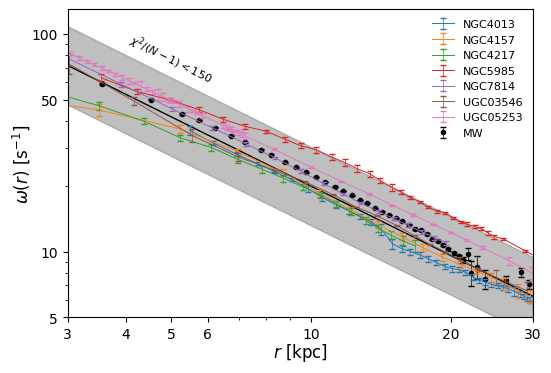

In [92]:
#Plotting angular velocity curves of MW and MW-like galaxies
fig,ax = plt.subplots(figsize = (6,4))

res = get_MWband()
logr, logw, loge, mw_line, Δc = res
logr = np.linspace(np.log10(3),np.log10(30),10)
mw_logw = mw_line[0]*logr + mw_line[1]

# RC plot for MW-like galaxies
for gal in mwgals:
    gdict = sparcd[prior][gal]
    r = np.array(gdict['r'])
    vc = np.array(gdict['vc'])
    ve = np.array(gdict['ve'])
    sc_mwlike = ax.errorbar(r, vc/r, ve/r, capsize = 2, fmt = '-',
                     elinewidth = 0.5,zorder = 2,
                     linewidth = 0.7,label = gal)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(3,30)
ax.set_ylim(5,130)

# RC plot of MW
er_mw = ax.errorbar(mw_r, mw_w, mw_we, c = 'k', fmt = '.', zorder = 1,
            alpha = 1, mec = 'k', capsize = 2,
            elinewidth = 0.5, label = 'MW')
fb_mw = ax.fill_between(10**logr, 10**(mw_logw + Δc), 10**(mw_logw - Δc),
                        color = 'grey',alpha = 0.5,zorder = 0)
pl_mw = ax.plot(10**logr, 10**mw_logw, c = 'k',linewidth = 1, zorder = 1)


ax.set_xticks([3,4,5,6,10,20,30],minor = [])
ax.set_xticklabels([3,4,5,6,10,20,30],minor = [])
yticks = [5,10,50,100]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

ax.legend(framealpha = 0,prop = {'size': 8})

ax.set_xlabel('$r$ [kpc]',size = 12,labelpad = 0)
ax.set_ylabel('$\omega(r) \,\, \mathrm{[s^{-1}]}$',size = 12, labelpad = 0)

ax.text(4, 60, '$\chi^2/(N-1) < 150$',size = 8, rotation = -26.5);

# plt.savefig('../Output/figures/MW_like_RC.pdf',bbox_inches = 'tight',dpi = 300)

In [93]:
"""Too create a table of the form:
    --------------------------------------
    Galaxy      param1    param2    param3
    --------  --------  --------  --------
    MW               1         2         3
    gal1             1         2         3
    gal2             1         2         3
    --------------------------------------"""

params = ['$M_{200}$','$c_{200}$','$M_\mathrm{d,star}$',
          'R_\mathrm{d,star}','$M_\mathrm{d,gas}$',
          '$R_\mathrm{d,gas}$', '$M_\mathrm{d,bul}$'] 

gdict = lambda gal,key: np.array(sparcd[prior][gal][key])
gald = lambda gal,key: np.array(sparcd[prior][gal]['cusp_fit'][key])
witherr = lambda p: r'%.1f $\pm$ %.1f'%(p[0],p[1])
noerr = lambda p: f'${p:.1f}$'

m200_row = [witherr(1e-12*gald(gal, 'm200')) for gal in mwgals]
c200_row = [witherr(gald(gal, 'c200')) for gal in mwgals]
mdstar_row = [noerr(10**(gald(gal, 'lmdisk')[0] - 9)) for gal in mwgals]
rdstar_row = [witherr(gald(gal, 'rdstar')) for gal in mwgals]
mdgas_row = [noerr(10**(gald(gal, 'lmgas')[0] - 9)) for gal in mwgals]
rdgas_row = [witherr(gald(gal, 'rdgas')) for gal in mwgals]
mdbul_row = [noerr(10**(gald(gal, 'lmbul')[0] - 9)) for gal in mwgals]

table = np.array([m200_row, c200_row, mdstar_row, 
                  rdstar_row, mdgas_row, rdgas_row, 
                  mdbul_row]).T

mw_fid = MW_dict['fiducial_range']
keys = ['m200', 'c200', 'mdstar', 'rdstar', 'mdgas', 'rdgas', 'mdbul']
mw_params = [f'({mw_fid[key][0]:.1f}, {mw_fid[key][1]:.1f})' for key in keys]
table = np.vstack((mw_params, table))

In [94]:
from tabulate import tabulate
print (tabulate(table, headers = ['Galaxy'] + keys, tablefmt = 'simple',
                showindex = ['MW'] + mwgals))

Galaxy    m200           c200            mdstar        rdstar         mdgas        rdgas           mdbul
--------  -------------  --------------  ------------  -------------  -----------  --------------  -----------
MW        (0.9, 1.6)     (9.0, 17.0)     (42.0, 63.0)  (2.0, 4.0)     (1.0, 20.0)  (5.0, 20.0)     (8.0, 20.0)
NGC4013   1.6 $\pm$ 0.4  4.7 $\pm$ 0.7   $38.7$        3.5 $\pm$ 0.4  $3.9$        8.0 $\pm$ 0.1   $12.2$
NGC4157   1.2 $\pm$ 0.5  6.5 $\pm$ 1.5   $43.7$        2.3 $\pm$ 0.2  $10.9$       8.8 $\pm$ 0.1   $1.2$
NGC4217   1.8 $\pm$ 0.8  7.6 $\pm$ 1.4   $68.2$        2.9 $\pm$ 0.3  $3.4$        6.5 $\pm$ 0.1   $12.6$
NGC5985   1.5 $\pm$ 0.1  27.0 $\pm$ 1.1  $62.2$        7.0 $\pm$ 0.7  $15.4$       26.6 $\pm$ 0.2  $7.2$
NGC7814   1.1 $\pm$ 0.3  13.2 $\pm$ 2.3  $48.7$        2.5 $\pm$ 0.3  $1.4$        10.7 $\pm$ 0.2  $24.5$
UGC03546  0.9 $\pm$ 0.1  9.1 $\pm$ 1.0   $59.9$        3.8 $\pm$ 0.4  $3.6$        12.7 $\pm$ 0.2  $10.2$
UGC05253  1.2 $\pm$ 0.0  15.5 $\pm$ 0.7

In [96]:
# Storing data in MWlike (dict)

MWlike = {'gals':['MW']+mwgals,
          'mwgals':mwgals,
          'table':table,
          'params':params,
          'param_keys':keys,}

pm_10 = lambda x: np.array([x, 0.1*x])
MWlike['massmodels'] = {'m200': [1e-12*np.array(gald(gal, 'm200')) for gal in mwgals],
                        'c200': [np.array(gald(gal, 'c200')) for gal in mwgals],
                        'mdstar': [pm_10( 10**(gald(gal, 'lmdisk')[0] - 9) ) for gal in mwgals],
                        'rdstar': [np.array(gald(gal, 'rdstar')) for gal in mwgals],
                        'mdgas': [pm_10( 10**(gald(gal, 'lmgas')[0] - 9 ) ) for gal in mwgals],
                        'rdgas': [np.array(gald(gal, 'rdgas')) for gal in mwgals],
                        'mdbul': [pm_10( 10**(gald(gal, 'lmbul')[0] - 9 ) ) for gal in mwgals],
                        'rdbul': [np.array(gald(gal, 'rdbul')) for gal in mwgals],
                        'rs': [np.array(gald(gal, 'rs')) for gal in mwgals]}

for key in MWlike['param_keys']:
    MWlike['massmodels'][key] = np.array(MWlike['massmodels'][key])

for i, gal in enumerate(mwgals):
    MWlike['massmodels'][gal] = np.array([MWlike['massmodels'][key][i] for key in MWlike['param_keys']])

# pickle.dump(MWlike, open('../Output/MWlike_dict.pkl','wb'))

# 2. VDF of MWlike galaxies at r = 8 kpc (using chains obtained from previous study)

In [108]:
# DONT RUN THIS DATA ALREADY SAVED (~ 80 mins)
# obtain VDFs in gal frame and Earth frame
import sys,math
sys.path.append('../')
from project.energetics import EI_vdf as EI
from project.recoil import get_vdf_ert
import project.profiles as pp
from tqdm.notebook import tqdm
from scipy.signal import medfilt

sparcd, prior = json.load(open('../Accessory/sparc_dict.json','rb')), 'lcdm_reg'
chaind = pickle.load(open('../Accessory/chains_lcdm_reg_DDGB_8kpc.pkl','rb'))
MWlike = pickle.load(open('../Output/MWlike_dict.pkl','rb'))
gald = lambda gal, key: sparcd[prior][gal]['cusp_fit'][key]
gdict = lambda gal, key: sparcd[prior][gal][key]

MWlike['vdf_RCfit'] = {}

mwgals = MWlike['mwgals']

# Obtain escape velocity if its not present in chaind for a paraticular gal in mwgals
def get_vdf_mwlike(gal, Rsun = 8.0, n = 50):
    samproot = '/media/milan/94D4D4FAD4D4DF92/Pluviophile/Project_TIFR/Project_SM/Project_RC/obs_RC_v4/Output/cluster_out/nfw_fit/lcdm_reg/%s.npy'%gal
    data = np.load(samproot, allow_pickle = True)[()]
    samp = data['samples']
    sampN = len(samp[:,0])
    stepN = math.floor(float(sampN)/500.)
    if stepN < 1: stepN = 1
    vdfs = []
    vescs = []
    vcircs = []
    vdfEs = []
    vescEs = []
    v = np.linspace(1e-5, 700, 300)
    vE = np.linspace(1e-5, 900, 300)
    for i in tqdm(range(0, sampN, stepN)):
        params = samp[i]
        
        rs = pp.rs_nfw(params[0], params[1])
        mdstar = params[2]*10**(gdict(gal,'lmdisk_1')[0])
        rdstar = gald(gal, 'rdstar')[0]
        mdbul = params[3]*10**(gdict(gal, 'lmbul_1')[0])
        rdbul = gald(gal, 'rdbul')[0]
        mdgas = 10**gald(gal, 'lmgas')[0]
        rdgas = gald(gal, 'rdgas')[0]
        
        model = {'dm':['NFW',params[0],rs]}
        model['disk'] = ['EXP',np.log10(mdstar), rdstar]
        model['bulge'] = ['EXP',np.log10(mdbul), rdbul]
        model['gas'] = ['EXP',np.log10(mdgas), rdgas]
        
        ei = EI(model)
        vesc = ei.Vmax(Rsun)
        vescs.append(vesc)

        ei_vdf = ei.get_vdf(Rsun, n)
        v_, vdf_ = ei_vdf[:,0], ei_vdf[:,1]
        vdf_ = medfilt(vdf_, kernel_size = 3)
        vdf = sp.interpolate.interp1d(v_, vdf_, kind = 'cubic',
                                      fill_value = 0,
                                      bounds_error = False)(v)
        vdfs.append(vdf)

        vdark = pp.v_nfw(params[0], rs, Rsun)
        vdstar = pp.v_exp(np.log10(mdstar), rdstar, Rsun)
        vdgas = pp.v_exp(np.log10(mdgas), rdgas, Rsun)
        vdbul = pp.v_exp(np.log10(mdbul), rdbul, Rsun)
        vcirc = np.sqrt(vdark**2 + vdstar**2 + vdbul**2 + vdgas**2)
        vcircs.append(vcirc)

        vdfE = get_vdf_ert(vE, v_, vdf_, vesc, vcirc)
        vdfEs.append(vdfE)

        indx = np.where((vdfE < 1e-5) & (vE > 300))[0]
        if np.any(indx):
            vescEs.append(vE[indx][0])
        else:
            vescEs.append(vE[-1])

    vdfs = np.array(vdfs)
    nan_mask = np.isnan(vdfs).any(axis=1)
    vdfs = vdfs[~nan_mask]
    vescs = np.array(vescs)[~nan_mask]
    vcircs = np.array(vcircs)[~nan_mask]
    vdfEs = np.array(vdfEs)[~nan_mask]
    vescEs = np.array(vescEs)[~nan_mask]

    return (v, vdfs, vescs, vcircs, vE, vdfEs, vescEs)


for gal in tqdm(mwgals):
    v, vdfs, vescs, vcircs, vE, vdfEs, vescEs = get_vdf_mwlike(gal)

    vdf_16, vdf_50, vdf_84 = np.percentile(vdfs, [16,50,84], axis = 0)
    vdfE_16, vdfE_50, vdfE_84 = np.percentile(vdfEs, [16, 50, 84], axis = 0)
    vesc_16, vesc_50, vesc_84 = np.percentile(vescs, [16, 50, 84], axis = 0)

    MWlike['vdf_RCfit'][gal] = {}
    RC = MWlike['vdf_RCfit'][gal]

    RC['v'], RC['vdfs'] = v, vdfs
    RC['vdf_16'], RC['vdf_50'], RC['vdf_84'] = vdf_16, vdf_50, vdf_84
    RC['vescs'], RC['vcircs'] = vescs, vcircs
    RC['vE'], RC['vdfEs'] = vE, vdfEs
    RC['vdfE_16'], RC['vdfE_50'], RC['vdfE_84'] = vdfE_16, vdfE_50, vdfE_84
    RC['vescEs'] = vescEs

pickle.dump(MWlike, open('../Output/MWlike_dict.pkl','wb'))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

In [109]:
# FOR PLOTTING
MWlike = pickle.load(open('../Output/MWlike_dict.pkl','rb'))
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))

def plot_vdfs(ax = None):
    if not ax:
        fig,ax = plt.subplots(figsize = (5,4))
    for gal in mwgals:
        RC = MWlike['vdf_RCfit'][gal]
        ax.plot('v', 'vdf_50', data = RC, lw = 0.8,label = gal)
        ax.fill_between('v', 'vdf_16', 'vdf_84', data = RC, alpha = 0.2)

    RC_mw = MW_dict['vdf_RCfit']
    ax.plot('v', 'vdf_50', data = RC_mw, c = 'k', lw = 0.8, label = 'MW', zorder = 2)
    ax.fill_between('v', 'vdf_16', 'vdf_84', data = RC_mw, color = 'k', alpha = 0.3, zorder = 2)

    ax.tick_params(direction = 'in', right = True, top = True)

    ax.set_yticks([0e-3, 1e-3, 2e-3, 3e-3, 4e-3])
    ax.set_yticklabels(['0','1','2','3','4'])
    ax.set_xlim(0,700)
    ax.set_xlabel('$v$ (kpc)',labelpad = 0)
    ax.set_ylabel(r'$v^2 \, f(v) \times 10^{-3}$ (normalized)',labelpad = 0)
    return ax

def plot_vdfEs(ax = None):
    if not ax:
        fig,ax = plt.subplots(figsizse = (5,4))
    for gal in mwgals:
        RC = MWlike['vdf_RCfit'][gal]
        ax.plot('vE', 'vdfE_50', data = RC, lw = 0.8,label = gal)
        ax.fill_between('vE', 'vdfE_16', 'vdfE_84', data = RC,
                        alpha = 0.2)

    RC_mw = MW_dict['vdf_RCfit']
    ax.plot('vE', 'vdfE_50', data = RC_mw, c = 'k', lw = 0.8, label = 'MW',zorder = 2)
    ax.fill_between('vE', 'vdfE_16', 'vdfE_84', data = RC_mw, color = 'k', alpha = 0.3,zorder = 2)
    
    ax.set_xlim(0,850)
    ax.legend(framealpha = 0, prop = {'size':8})
    ax.set_xlabel('$v_E$ (kpc)',labelpad = 0)
    ax.set_ylabel(r'$v_E^2\,f_E(v_E) \times 10^{-3}$ (normalized)',labelpad = 0)

    ax.set_yticks([0, 0.5e-3, 1e-3, 1.5e-3, 2e-3, 2.5e-3, 3e-3])
    ax.set_yticklabels(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
    ax.tick_params(direction = 'in', right = True, top = True)
    return ax

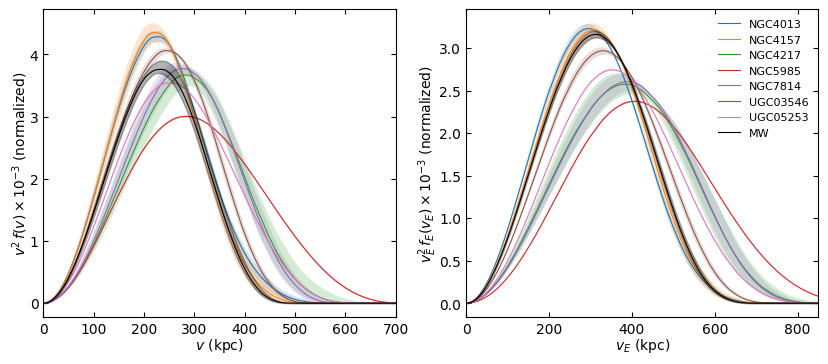

In [118]:
fig,axs = plt.subplots(1,2,figsize = (10,4))
ax1,ax2 = axs

ax1 = plot_vdfs(ax1);
ax2 = plot_vdfEs(ax2);

plt.savefig('../Output/figures/All_VDFs.png',bbox_inches = 'tight', dpi = 300)